# **Machine Learning Model**

This notebook implements a convolutional neural network to recognise different physical activities from Respeck sensor data. The dataset includes multiple 30-second recordings of various physical activities (e.g., ascending stairs, shuffle walking, sitting-standing) stored in separate CSV files for each activity.

This model will be deployed inside the Android app for live classification.


# Imports

In [14]:
# Importing libraries that will be used
import pandas as pd
import numpy as np
import glob
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input, LSTM, Attention
from tensorflow.keras.models import Model
from sklearn.utils import resample
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold

# Reading Files
Reading files from your dataset

In [15]:
# Path to Respeck data
your_dataset_path = "./PDIoT2324/Respeck/"

This line uses the glob module to find all file paths that match a specified pattern. The 'glob.glob()' function returns a list of file paths that match the given pattern. `your_dataset_path` should be the directory where your dataset files are located.

The `*` is a wildcard character that matches any string of characters,  so this pattern retrieves all folders in the 'your_dataset_path' directory.

In [16]:
glob.glob(your_dataset_path + "*")

['./PDIoT2324/Respeck\\s100_respeck_ascending_breathingNormal.csv',
 './PDIoT2324/Respeck\\s100_respeck_descending_breathingNormal.csv',
 './PDIoT2324/Respeck\\s100_respeck_lyingBack_breathingNormal.csv',
 './PDIoT2324/Respeck\\s100_respeck_lyingBack_coughing.csv',
 './PDIoT2324/Respeck\\s100_respeck_lyingBack_hyperventilating.csv',
 './PDIoT2324/Respeck\\s100_respeck_lyingBack_laughing.csv',
 './PDIoT2324/Respeck\\s100_respeck_lyingBack_singing.csv',
 './PDIoT2324/Respeck\\s100_respeck_lyingBack_talking.csv',
 './PDIoT2324/Respeck\\s100_respeck_lyingLeft_breathingNormal.csv',
 './PDIoT2324/Respeck\\s100_respeck_lyingLeft_coughing.csv',
 './PDIoT2324/Respeck\\s100_respeck_lyingLeft_hyperventilating.csv',
 './PDIoT2324/Respeck\\s100_respeck_lyingLeft_laughing.csv',
 './PDIoT2324/Respeck\\s100_respeck_lyingLeft_singing.csv',
 './PDIoT2324/Respeck\\s100_respeck_lyingLeft_talking.csv',
 './PDIoT2324/Respeck\\s100_respeck_lyingRight_breathingNormal.csv',
 './PDIoT2324/Respeck\\s100_respeck_

# Functions

## Load list of files in an activity folder

In [ ]:
# Define activities and social signals with corresponding labels
# Each key is the name of the physical activity, and the corresponding value is the numeric label
# These labels will be used as the target variable for classification

activities = {
    'ascending': 0,
    'shuffleWalking': 1,
    'sittingStanding': 2,
    'miscMovement': 3,
    'normalWalking': 4,
    'lyingBack': 5,
    'lyingLeft': 6,
    'lyingRight': 7,
    'lyingStomach': 8,
    'descending': 9,
    'running': 10
}

social_signals = {
    'breathingNormal': 0,
    'coughing': 1,
    'hyperventilating': 2,
    'other': 3
}

activity_labels = list(activities.keys())
social_signal_labels = list(social_signals.keys())


In [17]:
def load_files_from_folder(folder_path):
    """
    Load all CSV files from a folder and return a list of file paths.

    Parameters:
    folder_path (str): The path to the folder containing CSV files.

    Returns:
    list: A list of file paths for all CSV files in the folder.
    """

    # Initialize an empty list to store the full file paths of the CSV files
    file_paths = []

    # Loop through all the files in the given folder
    for file_name in os.listdir(folder_path):
        # Check if the file has a .csv extension (ignores other files)
        if file_name.endswith('.csv'):
            # Construct the full file path by joining the folder path and the file name
            full_file_path = os.path.join(folder_path, file_name)

            # Append the full file path to the file_paths list
            file_paths.append(full_file_path)

    # Return the complete list of CSV file paths
    return file_paths

## Train and test set split from list of files

Create `social_signal_train_files`, `social_signal_test_files`, `activity_train_files` and `activity_test_files` from the dataset.

In [74]:
# Function to extract either the activity or the social signal label from the file name
def extract_task(file_name, task):
    """
    Extract the activity or social signal label from a file name.

    Parameters:
    file_name (str): The name of the file containing the label.
    task (str): The task to extract from the file name (e.g., 'activity' or 'social_signal').

    Returns:
    str: The extracted label from the file name.
    """

    # Split the file name by underscores to extract different parts
    file_parts = file_name.split('_')

    # Check if the task is 'activity'
    if task == 'activity':
        # The activity label is the second part of the file name
        label = file_parts[2]
    # Check if the task is 'social_signal'
    elif task == 'social_signal':
        # The social signal label is the third part of the file name
        label = file_parts[3].split(".")[0]

    if label == "sitting" or label == "standing":
        label = "sittingStanding"

    if label == "laughing" or label == "talking" or label == "eating" or label == "singing":
        label = "other"

    if task == "activity":
        label = activities[label]
    else:
        label = social_signals[label]
    # Return the extracted label
    return label


In [75]:
def split_files(file_list, task, test_size=0.2):
    """
    Split the list of files into training and test sets.

    Parameters:
    file_list (list): List of file paths to be split into train and test sets.
    test_size (float): The proportion of files to allocate to the test set.
                       Default is 0.2, meaning 20% of the files will be used for testing.

    Returns:
    tuple:
        - train_files (list): List of file paths for the training set.
        - test_files (list): List of file paths for the test set.
    """
    labels = []
    for file in file_list:
        label = extract_task(file, task)
        labels.append(label)

    
    train_files, test_files = train_test_split(file_list, test_size=test_size, stratify=labels, random_state=42)

    # Return the train and test file lists
    return train_files, test_files

## Sliding Window

In time series Activity Recognition, a sliding window is a commonly used technique to segment continuous sensor data (such as accelerometer readings) into smaller, fixed-length overlapping or non-overlapping time intervals, or windows. Each window contains a sequence of sensor measurements that represent a short period of time, and this segmented data is used to extract features or make predictions about the activity happening within that window.

### Key Concepts of a Sliding Window
1.   **Window Size:** This refers to the length of each segment or window, typically defined in terms of the number of time steps or the duration (e.g., 2 seconds). The window size should be chosen carefully to capture enough information about the activity without making the window too large.
2.   **Step Size:** The step size determines how far the window moves forward after each step. If the step size is smaller than the window size, the windows will overlap. For example, if the window size is 5 seconds and the step size is 2 seconds, there will be a 3-second overlap between consecutive windows. Overlapping windows provide more data for analysis and can help smooth out predictions by capturing transitional activities.
3.   **Non-Overlapping Windows:** If the step size is equal to the window size, the windows do not overlap. This method provides distinct segments of data but may miss transitional phases between activities.

### Why Sliding Windows for Activity Recognition?

* Segmentation of Continuous Data: Activity recognition systems work with continuous streams of sensor data, and the sliding window helps segment these into manageable pieces to classify activities within specific intervals.

* Context Capturing: Human activities are often complex and spread across time. By using a sliding window, you can capture context across a short duration, which may include transitions or small fluctuations in the activity (e.g., a person moving from sitting to standing).

* Feature Extraction: Within each window, features such as mean, variance, frequency domain features, etc., can be extracted to help classify the activity.

* Real-Time Recognition: In real-time systems, the sliding window allows for continuous monitoring and updating of predictions as new data arrives.



In [76]:
def load_and_apply_sliding_windows(file_paths, window_size, step_size, task):
    """
    Load the data from each file, apply sliding windows, and return the windows and labels.

    Parameters:
    file_paths (list): List of file paths to CSV files. Each file contains sensor data (e.g., accelerometer, gyroscope).
    window_size (int): The size of each sliding window (number of time steps).
    step_size (int): The step size (stride) between consecutive windows.
    label (int or str): The label for the activity corresponding to the folder.
                        This label will be assigned to each sliding window extracted from the data.

    Returns:
    tuple:
        - windows (numpy.ndarray): A 3D array of sliding windows, where each window has the shape
                                   (num_windows, window_size, num_features).
        - labels (numpy.ndarray): A 1D array of labels, where each label corresponds to a sliding window.
    """
    # Initialize lists to store sliding windows and their corresponding labels
    windows = []
    labels = []

    # Loop through each file in the provided file paths
    for file_path in file_paths:
        label = extract_task(file_path, task)
        # Load the CSV file into a pandas DataFrame
        data = pd.read_csv(file_path)

        # Select the columns containing the necessary sensor data (acceleration and gyroscope readings)
        # These columns might vary depending on your dataset's structure
        data = data[['accel_x', 'accel_y', 'accel_z']]

        # Convert the DataFrame into a numpy array for faster processing in the sliding window operation
        data = data.to_numpy()

        # Get the number of samples (rows) and features (columns) in the data
        num_samples, num_features = data.shape

        # Apply sliding windows to the data
        # The range function defines the start of each window, moving step_size increments at a time
        for i in range(0, num_samples - window_size + 1, step_size):
            # Extract a window of size 'window_size' from the current position 'i'
            window = data[i:i + window_size, :]

            # Append the window to the windows list
            windows.append(window)

            # Assign the activity label to the window and append it to the labels list
            labels.append(label)

    # Convert the lists of windows and labels into numpy arrays for efficient numerical operations
    return np.array(windows), np.array(labels)

## Load and Split Train Test for Each Activity Folder

This function processes the sensor data for a specific activity, such as 'walking' or 'running', stored in its respective folder. It splits the data into training and testing sets, applies sliding windows, and labels the windows with the corresponding activity. This function can be used repeatedly for each activity to process and prepare data for training and evaluation.

In [77]:
def process_task(task, label_list, dataset_path, window_size=50, step_size=50, test_size=0.2):
    """
    Processes an activity folder by loading the file list, splitting them into
    train and test sets, and applying sliding windows to the files.

    Args:
        activity (str): Name of the activity (folder name). This refers to the specific physical activity
                        like 'walking', 'running', etc.
        label (int): Numeric label corresponding to the activity, used for classification.
        dataset_path (str): Base path where the activity folders are located.
        window_size (int): Size of the sliding window, i.e., the number of time steps included in each window.
                           Default is 50.
        step_size (int): Step size for the sliding window, i.e., how far the window moves along the data.
                         Default is 50 (no overlap between windows).
        test_size (float): Proportion of files to use for testing. Default is 0.2, meaning 20% of files will
                           be allocated to the test set.

    Returns:
        tuple:
            - train_windows (numpy.ndarray): Sliding windows from the training files.
            - train_labels (numpy.ndarray): Corresponding labels for the training windows.
            - test_windows (numpy.ndarray): Sliding windows from the test files.
            - test_labels (numpy.ndarray): Corresponding labels for the test windows.
    """

    # Load all CSV file paths for the given activity from the folder
    file_list = load_files_from_folder(dataset_path)

    # Split the file list into training and testing sets
    # train_files: files used for training
    # test_files: files used for testing
    train_files, test_files = split_files(file_list, task, test_size=test_size)
    
    # Apply sliding windows to the training files
    # The function 'load_and_apply_sliding_windows' returns the sliding windows (segments) and their corresponding labels
    train_windows, train_labels = load_and_apply_sliding_windows(train_files, window_size, step_size, task)

    # Apply sliding windows to the testing files
    test_windows, test_labels = load_and_apply_sliding_windows(test_files, window_size, step_size, task)

    # Return the sliding windows and their labels for both training and testing sets
    return train_windows, train_labels, test_windows, test_labels

## Combine Data
The function combines the sliding window data and their corresponding labels from multiple activities (e.g., walking, running, etc.) into single arrays.

In [78]:
def combine_data(train_test_data, data_type):
    """
    Combines the sliding windows and labels from all activities into a single
    array for either training or testing.

    Args:
        train_test_data (dict): Dictionary containing the sliding window data for all activities.
                                Each key in the dictionary corresponds to an activity, and the value is another
                                dictionary with the keys 'train_windows', 'train_labels', 'test_windows', 'test_labels'.
        data_type (str): Either 'train' or 'test' to specify which data to combine (e.g., 'train_windows' or 'test_windows').

    Returns:
        tuple:
            - windows (numpy.ndarray): Concatenated windows from all activities for either training or testing.
            - labels (numpy.ndarray): Concatenated labels corresponding to the windows from all activities.
    """

    # Extract the list of sliding windows for the specified data type (either 'train' or 'test') from each activity
    # For example, if data_type is 'train', it extracts 'train_windows' for all activities
    windows_list = [train_test_data[activity][f'{data_type}_windows'] for activity in train_test_data]

    # Similarly, extract the list of labels corresponding to the windows for each activity
    labels_list = [train_test_data[activity][f'{data_type}_labels'] for activity in train_test_data]

    # Concatenate all the sliding windows into a single numpy array along the first axis (rows)
    # This creates one large array of windows from all the activities combined
    concatenated_windows = np.concatenate(windows_list, axis=0)

    # Concatenate all the labels into a single numpy array along the first axis (rows)
    # The labels are now aligned with the concatenated windows
    concatenated_labels = np.concatenate(labels_list, axis=0)

    # Return the concatenated windows and labels as a tuple
    return concatenated_windows, concatenated_labels

## 1D CNN Model

This function, `build_1d_cnn_model`, creates and compiles a 1D Convolutional Neural Network (CNN) for multi-label classification tasks.

### Function Overview

Input Parameters
* `input_shape`: Specifies the shape of the input data. It represents (timesteps, features), where timesteps refer to the length of the time series (e.g., 50 windows), and features represent the number of measurements in each time step (e.g., accelerometer readings).
* `num_activity_classes`: The number of output classes for the activity classification problem.
* `num_social_signal_classes`: The number of output classes for the social signal classification problem.

Returns
* The function returns a compiled 1D CNN model with two outputs that is ready to be trained on your data.

<hr>

### Function Breakdown
1. **Model Initialization:**
    * `inputs = Input(shape=input_shape)`: Initializes the input layer with the specified shape.
2. **First Convolutional Layer:**
    * `Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)`
        * This is the first 1D convolutional layer.
        * `filters=64`: The layer applies 64 filters (or kernels) over the input data.
        * `kernel_size=3`: Each filter will cover 3 timesteps at a time (a window of 3).
        * `activation='relu'`: The Rectified Linear Unit (ReLU) activation function introduces non-linearity and helps the model learn complex patterns.
    * `MaxPooling1D(pool_size=2)(x)`: This pooling layer reduces the dimensionality of the data by taking the maximum value from each 2-timestep window (`pool_size=2`).
3. **Second Convolutional Layer:**
    * `Conv1D(filters=128, kernel_size=3, activation='relu')(x)`
        * This is the second convolutional layer, similar to the first, but with 128 filters.
        * `kernel_size=3` and `activation='relu'` function in the same way as the first Conv1D layer.
    * `MaxPooling1D(pool_size=2)(x)`: Another pooling layer to downsample the output, further reducing the data’s dimensionality.
4. **Flattening Layer:**
    * `Flatten()(x)`: Converts the 2D output of the convolutional and pooling layers into a 1D vector.
5. **Fully Connected Layer:**
    * `Dense(128, activation='relu')(x)`: This is a fully connected layer with 128 units/neurons.
6. **Dropout Layer:**
    * `Dropout(0.5)(x)`: This layer randomly sets 50% of the neurons to zero during training to prevent overfitting.
7. **Output Layer for Activity Classification:**
    * `Dense(num_activity_classes, activation='softmax', name='activity_output')(x)`: This is the output layer for activity classification with `num_activity_classes` neurons.
8. **Output Layer for Social Signal Classification:**
    * `Dense(num_social_signal_classes, activation='softmax', name='social_signal_output')(x)`: This is the output layer for social signal classification with `num_social_signal_classes` neurons.
9. **Model Definition:**
    * `model = Model(inputs=inputs, outputs=[activity_output, social_signal_output])`: Defines the model with two outputs.
10. **Compiling the Model:**
    * `model.compile(optimizer='adam', loss={'activity_output': 'categorical_crossentropy', 'social_signal_output': 'categorical_crossentropy'}, metrics={'activity_output': 'accuracy', 'social_signal_output': 'accuracy'})`
        * Optimizer: 'adam': Adam is an optimization algorithm that adjusts the learning rate during training to improve performance.
        * Loss: 'categorical_crossentropy': This loss function is used for multi-class classification problems where the target variable is one-hot encoded.
        * Metrics: ['accuracy']: The accuracy metric is used to evaluate the model’s performance during training and testing.

In [79]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

def build_activity_model(input_shape, num_activity_classes):
    inputs = Input(shape=input_shape)

    # Convolutional and pooling layers
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(filters=128, kernel_size=3, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)

    # Flatten and fully connected layers
    x = Flatten()(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)

    # Output layer for activity classification
    activity_output = Dense(num_activity_classes, activation='softmax', name='activity_output')(x)

    # Define and compile the model
    model = Model(inputs=inputs, outputs=activity_output)
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [80]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2

def build_social_signal_model(input_shape, num_social_signal_classes):
    """
    Builds and compiles a 1D CNN model for social signal classification.
    
    Args:
        input_shape (tuple): The shape of the input data (timesteps, features).
        num_social_signal_classes (int): The number of output social signal classes.
    
    Returns:
        model (Model): Compiled 1D CNN model for social signal classification.
    """
    # Input layer
    inputs = Input(shape=input_shape)

    # Shared Conv1D layers
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
    x = MaxPooling1D(pool_size=2)(x)

    # Additional Conv1D layers for social signal classification
    x = Conv1D(filters=128, kernel_size=3, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)

    # Flatten, fully connected layer, and output layer
    x = Flatten()(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    social_signal_output = Dense(num_social_signal_classes, activation='softmax', name='social_signal_output')(x)

    # Define and compile the model
    model = Model(inputs=inputs, outputs=social_signal_output)
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


# Classification Pipeline

## Step 1: Prepare and Preprocess the Data

In [86]:
X_train_activity, y_train_activity, X_test_activity, y_test_activity = process_task("activity", activity_labels, your_dataset_path)
X_train_social_signal, y_train_social_signal, X_test_social_signal, y_test_social_signal = process_task("social_signal", social_signal_labels, your_dataset_path)

print(f"Length of training data for activity {len(X_train_activity)} with {len(set(y_train_activity))} different labels")
print(f"Length of training data for social signal {len(X_train_social_signal)} with {len(set(y_train_social_signal))} different labels")	

print(f"Length of test data for activity is {len(X_test_activity)} with {len(set(y_test_activity))} different labels")
print(f"Length of test data for social signal is {len(X_test_social_signal)} with {len(set(y_test_social_signal))} different labels")

Length of training data for activity 48578 with 11 different labels
Length of training data for social signal 48580 with 4 different labels
Length of test data for activity is 12151 with 11 different labels
Length of test data for social signal is 12149 with 4 different labels


Now the training and testing data will be created by calling the function `process_activity`. The `process_activity` function is used to generate sliding windows and labels for the training and testing sets.
* `X_train` and `X_test` are 3D arrays of sliding windows (shape: num_windows, window_size, num_features).
* `y_train_activity` and `y_train_social_signal` are 1D arrays of activity and social signal labels for the training set.
* `y_test_activity` and `y_test_social_signal` are 1D arrays of activity and social signal labels for the testing set.

Now the training and testing sets generated by the `process_activity` function are checked to see that they have the correct shape.

### One-Hot Encode Labels (for multi-class classification)
Since there are more than two classes, the labels must be one-hot encoded, especially as the model will use categorical cross-entropy loss.

One-Hot Encoding converts categorical labels into binary vectors (one-hot encoded format). Each class label is represented as a binary vector with 1 for the correct class and 0 for others. This is necessary for training models that use categorical_crossentropy as the loss function, such as a neural network.

In [101]:
# Initialise the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Fit the OneHotEncoder on the training activity labels and transform them to one-hot encoded format
y_train_activity_one_hot = encoder.fit_transform(y_train_activity.reshape(-1, 1))

# Transform the test activity labels to one-hot encoded format using the already fitted encoder
y_test_activity_one_hot = encoder.transform(y_test_activity.reshape(-1, 1))


# Fit the OneHotEncoder on the training social signal labels and transform them to one-hot encoded format
y_train_social_signal_one_hot = encoder.fit_transform(y_train_social_signal.reshape(-1, 1))

# Transform the test social signal labels to one-hot encoded format using the already fitted encoder
y_test_social_signal_one_hot = encoder.transform(y_test_social_signal.reshape(-1, 1))

# Explanation:
# - y_train_activity_one_hot, y_train_social_signal_one_hot, y_test_activity_one_hot and y_test_social_signal_one_hot are now 2D arrays where each row is a one-hot encoded binary vector corresponding to a class label.
# - The number of columns in the one-hot encoded labels equals the number of unique classes (activities).
# For example, if there are 6 unique activities, the encoded vector will have 6 elements, with a '1' indicating the correct class.

In [102]:
# Print the shapes of the one-hot encoded labels to verify that the transformation was successful
print(f"y_train_activity_one_hot shape: {y_train_activity_one_hot.shape}, y_train_social_signal_one_hot shape: {y_train_social_signal_one_hot.shape}, y_test_activity_one_hot shape: {y_test_activity_one_hot.shape}, y_test_social_signal_one_hot shape: {y_test_social_signal_one_hot.shape}")

# Explanation of shapes:
# - The shape of y_train_activity_one_hot will be (num_samples, num_classes), where:
#     - num_samples is the number of training windows.
#     - num_classes is the number of unique activities (the length of the one-hot vectors).
# - Similarly, y_test_activity_one_hot will have the same number of columns (num_classes) as y_train_activity_one_hot but will have fewer rows (corresponding to the number of test windows).

y_train_activity_one_hot shape: (88697, 11), y_train_social_signal_one_hot shape: (88697, 4), y_test_activity_one_hot shape: (22179, 11), y_test_social_signal_one_hot shape: (22179, 4)


## Step 2: Build the 1D-CNN Model
Call our `build_1d_cnn_model` function to build our model

In [103]:
# Determine the input shape for the model
input_shape = (X_train.shape[1], X_train.shape[2])

# Determine the number of output classes (num_classes)
num_activity_classes = y_train_activity_one_hot.shape[1]
num_social_signal_classes = y_train_social_signal_one_hot.shape[1]

# Build and compile the model
# The function will return a compiled model ready for training
model = build_1d_cnn_model(input_shape, num_activity_classes, num_social_signal_classes)

## Step 3: Train and Evaluate the CNN Model

Train the 1D CNN model using the training data and validate on the test data. The model will learn to map input sliding windows to their corresponding activity and social signal labels.

`model.fit()` is used to train the neural network model. It takes several parameters:
* `X_train`: The input training data (sliding windows), with shape (num_samples, window_size, num_features).
* `{'activity_output': y_train_activity_one_hot, 'social_signal_output': y_train_social_signal_one_hot}`: The corresponding one-hot encoded labels for the training data, with shape (num_samples, num_classes).
* `epochs`: Number of times the entire training dataset is passed through the model. In this case, we are training for 20 epochs, meaning the model will see the entire training set 20 times.
* `batch_size`: Number of samples processed before the model's weights are updated. Here, the batch size is set to 32, meaning the model will process 32 samples at a time before updating its parameters.
* `validation_data`: This parameter allows us to evaluate the model's performance on the test data after each epoch. It takes the test data and corresponding one-hot encoded test labels.

After training, the model is evaluated on the test set. This is done with  5-Fold Cross-Validation.

`val_accuracy` is the accuracy of the model on the validation data (in this case X_test, y_test_activity_one_hot and y_test_social_signal_one_hot). The `accuracy` is the training accuracy for the current epoch.

In [104]:
# Set up KFold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialise lists to store the accuracy of each fold
activity_accuracy = []
social_signal_accuracy = []

# Initialise lists to store the true and predicted labels for social signals for all folds
all_y_true_social_signal = []
all_y_pred_social_signal = []

# Perform KFold cross-validation
fold_no = 1

for train_index, val_index in kfold.split(X_train):
    print(f"Training fold {fold_no}")

    # Split the data for this fold
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_activity_fold, y_val_activity_fold = y_train_activity_one_hot[train_index], y_train_activity_one_hot[val_index]
    y_train_social_signal_fold, y_val_social_signal_fold = y_train_social_signal_one_hot[train_index], y_train_social_signal_one_hot[val_index]

    # Train and evaluate Activity model
    activity_model = build_activity_model(input_shape, num_activity_classes)
    activity_model.fit(
        X_train_fold, y_train_activity_fold,
        epochs=2,
        batch_size=32,
        validation_data=(X_val_fold, y_val_activity_fold),
        verbose=0
    )

    # Predictions and evaluation for Activity model
    y_pred_probs_activity = activity_model.predict(X_val_fold)
    y_pred_activity = np.argmax(y_pred_probs_activity, axis=1)
    y_true_activity = np.argmax(y_val_activity_fold, axis=1)
    report_activity = classification_report(y_true_activity, y_pred_activity, output_dict=True)
    activity_accuracy.append(report_activity['accuracy'])

    # Train and evaluate Social Signal model
    social_signal_model = build_social_signal_model(input_shape, num_social_signal_classes)
    social_signal_model.fit(
        X_train_fold, y_train_social_signal_fold,
        epochs=2,
        batch_size=32,
        validation_data=(X_val_fold, y_val_social_signal_fold),
        verbose=0
    )

    # Predictions and evaluation for Social Signal model
    y_pred_probs_social_signal = social_signal_model.predict(X_val_fold)
    y_pred_social_signal = np.argmax(y_pred_probs_social_signal, axis=1)
    y_true_social_signal = np.argmax(y_val_social_signal_fold, axis=1)
    report_social_signal = classification_report(y_true_social_signal, y_pred_social_signal, output_dict=True)
    social_signal_accuracy.append(report_social_signal['accuracy'])

    # Collect predictions and true labels for confusion matrix
    all_y_true_social_signal.extend(y_true_social_signal)
    all_y_pred_social_signal.extend(y_pred_social_signal)

    print(f"Completed fold {fold_no}")
    fold_no += 1

# Calculate average accuracy across folds
average_activity_accuracy = np.mean(activity_accuracy)
average_social_signal_accuracy = np.mean(social_signal_accuracy)

# Convert the lists for the confusion matrix to numpy arrays
all_y_true_social_signal = np.array(all_y_true_social_signal)
all_y_pred_social_signal = np.array(all_y_pred_social_signal)

print(f"Average Activity Accuracy: {average_activity_accuracy:.4f}")
print(f"Average Social Signal Accuracy: {average_social_signal_accuracy:.4f}")


Training fold 1
555/555 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
555/555 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Completed fold 1
Training fold 2
555/555 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
555/555 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Completed fold 2
Training fold 3
555/555 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
555/555 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Completed fold 3
Training fold 4
555/555 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
555/555 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Completed fold 4
Training fold 5
555/555 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


c:\Users\seanc\miniconda3\envs\pdiot\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\seanc\miniconda3\envs\pdiot\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\seanc\miniconda3\envs\pdiot\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


555/555 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Completed fold 5
Average Activity Accuracy: 0.9301
Average Social Signal Accuracy: 0.6110


## Confusion Matrix

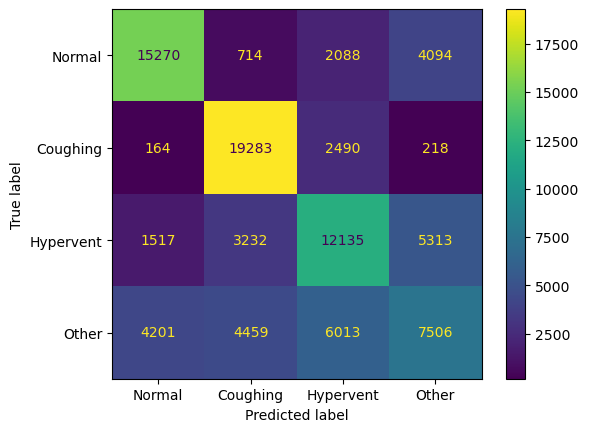

In [105]:
# Generate confusion matrix
cm = confusion_matrix(all_y_true_social_signal, all_y_pred_social_signal)
ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Coughing', 'Hypervent', 'Other']).plot()

# Exporting your model to TFLite

You can use the TFLiteConverter class provided by TensorFlow to convert your trained model into the TensorFlow Lite format. We export models to TensorFlow Lite (TFLite) for several reasons, primarily because TFLite is designed for deployment on edge devices, such as mobile phones, embedded systems, IoT devices, and microcontrollers, where computational resources and power are limited. This is necessary as you will be running your ML models on your Android devices to perform live classification.

In [106]:
import tensorflow as tf

# Assuming you have trained your models and they are stored in `activity_model` and `social_signal_model`

# Convert the activity model to TFLite
def export_activity_model_to_tflite(activity_model, filename="activity_model.tflite"):
    # Create a TFLiteConverter object from the Keras model
    converter = tf.lite.TFLiteConverter.from_keras_model(activity_model)
    
    # Convert the model
    tflite_activity_model = converter.convert()
    
    # Save the converted model to a file
    with open(filename, "wb") as f:
        f.write(tflite_activity_model)
    
    print(f"Activity model successfully exported to {filename}")


# Convert the social signal model to TFLite
def export_social_signal_model_to_tflite(social_signal_model, filename="social_signal_model.tflite"):
    # Create a TFLiteConverter object from the Keras model
    converter = tf.lite.TFLiteConverter.from_keras_model(social_signal_model)
    
    # Convert the model
    tflite_social_signal_model = converter.convert()
    
    # Save the converted model to a file
    with open(filename, "wb") as f:
        f.write(tflite_social_signal_model)
    
    print(f"Social signal model successfully exported to {filename}")


In [107]:
# Export both models to TFLite format
export_activity_model_to_tflite(activity_model, "activity_model.tflite")
export_social_signal_model_to_tflite(social_signal_model, "social_signal_model.tflite")

INFO:tensorflow:Assets written to: C:\Users\seanc\AppData\Local\Temp\tmpf7ue3myq\assets


INFO:tensorflow:Assets written to: C:\Users\seanc\AppData\Local\Temp\tmpf7ue3myq\assets


Saved artifact at 'C:\Users\seanc\AppData\Local\Temp\tmpf7ue3myq'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 50, 3), dtype=tf.float32, name='keras_tensor_610')
Output Type:
  TensorSpec(shape=(None, 11), dtype=tf.float32, name=None)
Captures:
  1478995596624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1478995605264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1478995593936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1478995593552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1478995597584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1478995595472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1478679314512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1478679329680: TensorSpec(shape=(), dtype=tf.resource, name=None)
Activity model successfully exported to activity_model.tflite
INFO:tensorflow:Assets written to: C:\Users\seanc\AppData\Local\Temp\tmpoq3qd25q\a

INFO:tensorflow:Assets written to: C:\Users\seanc\AppData\Local\Temp\tmpoq3qd25q\assets


Saved artifact at 'C:\Users\seanc\AppData\Local\Temp\tmpoq3qd25q'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 50, 3), dtype=tf.float32, name='keras_tensor_619')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  1478679327760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1478679330256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1478679326032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1478679330640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1478679327376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1478679315856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1478679328528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1478679329296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1478679327184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1478391096400: TensorSpec(shape=(), dtype=tf.resource, name=None)
Social si

## Testing the accuracy of the TFLite model

In [108]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report

# Load TFLite model and allocate tensors
activity_interpreter = tf.lite.Interpreter(model_path="activity_model.tflite")
activity_interpreter.allocate_tensors()

# Get input and output details
activity_input_details = activity_interpreter.get_input_details()
activity_output_details = activity_interpreter.get_output_details()

# Placeholder list for storing predictions
activity_predictions = []

# Run inference on each test sample
for i in range(len(X_test_activity)):
    # Set the input tensor to the test sample
    input_data = np.expand_dims(X_test_activity[i], axis=0).astype(np.float32)
    activity_interpreter.set_tensor(activity_input_details[0]['index'], input_data)

    # Run inference
    activity_interpreter.invoke()

    # Get the output tensor
    activity_output = activity_interpreter.get_tensor(activity_output_details[0]['index'])
    
    # Convert output to class prediction
    activity_pred = np.argmax(activity_output, axis=1)[0]
    activity_predictions.append(activity_pred)

# Convert one-hot encoded labels to class labels
y_true_activity = np.argmax(y_test_activity_one_hot, axis=1)

# Calculate accuracy
activity_accuracy = accuracy_score(y_true_activity, activity_predictions)

# Print accuracy and classification report
print(f"Activity Model Accuracy: {activity_accuracy:.4f}")
print("Activity Model Classification Report:", classification_report(y_true_activity, activity_predictions))


NameError: name 'X_test_activity' is not defined

In [ ]:
# Load TFLite model and allocate tensors
social_signal_interpreter = tf.lite.Interpreter(model_path="social_signal_model.tflite")
social_signal_interpreter.allocate_tensors()

# Get input and output details
social_signal_input_details = social_signal_interpreter.get_input_details()
social_signal_output_details = social_signal_interpreter.get_output_details()

# Placeholder list for storing predictions
social_signal_predictions = []

# Run inference on each test sample
for i in range(len(X_test_social_signal)):
    # Set the input tensor to the test sample
    input_data = np.expand_dims(X_test_social_signal[i], axis=0).astype(np.float32)
    social_signal_interpreter.set_tensor(social_signal_input_details[0]['index'], input_data)

    # Run inference
    social_signal_interpreter.invoke()

    # Get the output tensor
    social_signal_output = social_signal_interpreter.get_tensor(social_signal_output_details[0]['index'])
    
    # Convert output to class prediction
    social_signal_pred = np.argmax(social_signal_output, axis=1)[0]
    social_signal_predictions.append(social_signal_pred)

# Convert one-hot encoded labels to class labels
y_true_social_signal = np.argmax(y_test_social_signal_one_hot, axis=1)

# Calculate accuracy
social_signal_accuracy = accuracy_score(y_true_social_signal, social_signal_predictions)

# Print accuracy and classification report
print(f"Social Signal Model Accuracy: {social_signal_accuracy:.4f}")
print("Social Signal Model Classification Report:", classification_report(y_true_social_signal, social_signal_predictions))


ValueError: Could not open 'social_signal_model.tflite'.